In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [2]:
df_train = pd.read_csv("../data/sparse/train_new2.csv")
df_test = pd.read_csv("../data/sparse/test_new2.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 694)

In [3]:
test_ids.shape

(48744,)

In [4]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

positive_data = None
negative_data = None


In [5]:
learning_rate = 0.1
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.05
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9
}

In [9]:
NFOLDS = 5

#X = features_train_t.values
X_test = df_test.values

labels_train = df_labels.values
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))
x_score = []

best_trees = []
fold_scores = []
N = 16

oof_train_full = []
oof_test_full = [] 
for s in range(N):
    
    
    params['seed'] = s
    
    x_train , x_val , y_train , y_val = train_test_split( df_train , df_labels , test_size = 0.2 , random_state=s)

    positive_indx = y_train[ y_train == 1 ]
    positive_data = x_train.loc[ positive_indx.index.values  ]


    negative_indx = y_train[ y_train == 0 ]
    negative_data = x_train.loc[  negative_indx.index.values  ]
    negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s*5 )

    print(positive_data.shape)
    print(negative_data.shape )

    labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

    x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
    x_train_sampled["y"] = labels
    x_train_sampled = x_train_sampled.sample(frac = 1 ,random_state = s )
    labels_sampled = x_train_sampled["y"].values
    
    x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 ).values
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf = kfold.split( x_train_sampled , labels_sampled  )
    best_trees = []
    fold_scores = []
    
    cv_train = np.zeros( len( labels_sampled ))
    #cv_eval_total = np.zeros( len( y_val ) )
    
    cv_pred = np.zeros( len( test_ids ) )
    
    
    oof_train = np.zeros((  len( labels_train ) , ))
    oof_test = np.zeros((  len( test_ids )  , ))
    
    
    oof_test_skf = np.empty((NFOLDS, len( test_ids )  ))
    oof_train_skf = np.empty((NFOLDS, len( labels_train )  ))
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = x_train_sampled[train_fold, :], x_train_sampled[validate, :], labels_sampled[train_fold], labels_sampled[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
        #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  X_test , num_iteration = bst.best_iteration )
        #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )
                
        cv_train[validate] += bst.predict( X_validate )
        
        
        oof_train_skf[i, :] = bst.predict( df_train.values )
        oof_test_skf[ i , : ] = bst.predict( X_test )
        
    oof_test[:] = oof_test_skf.mean( axis = 0 )
    oof_train[:] = oof_train_skf.mean( axis = 0 )
    
    oof_train = oof_train.reshape(-1, 1)
    oof_test = oof_test.reshape( -1 , 1 )
    
    oof_train_full.append( oof_train ) 
    oof_test_full.append( oof_test )

    cv_pred /= NFOLDS
    final_cv_pred += cv_pred    

    print("cv score:")
    print( roc_auc_score( labels_sampled , cv_train )   )
    

    

(19970, 694)
(19850, 694)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.603521	valid_0's auc: 0.74202
[200]	valid_0's binary_logloss: 0.588559	valid_0's auc: 0.754722
[300]	valid_0's binary_logloss: 0.584641	valid_0's auc: 0.757484
[400]	valid_0's binary_logloss: 0.583798	valid_0's auc: 0.757859
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.582742	valid_0's auc: 0.759199
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.607241	valid_0's auc: 0.738263
[200]	valid_0's binary_logloss: 0.589674	valid_0's auc: 0.755784
[300]	valid_0's binary_logloss: 0.584145	valid_0's auc: 0.760417
[400]	valid_0's binary_logloss: 0.581614	valid_0's auc: 0.762814
[500]	valid_0's binary_logloss: 0.580397	valid_0's auc: 0.764054
[600]	valid_0's binary_logloss: 0.580196	valid_0's auc: 0.764427
Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.579952	valid_0's auc: 0.764496

[300]	valid_0's binary_logloss: 0.574249	valid_0's auc: 0.771041
[400]	valid_0's binary_logloss: 0.571915	valid_0's auc: 0.772945
[500]	valid_0's binary_logloss: 0.571356	valid_0's auc: 0.773681
Early stopping, best iteration is:
[478]	valid_0's binary_logloss: 0.571208	valid_0's auc: 0.773847
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.599815	valid_0's auc: 0.746911
[200]	valid_0's binary_logloss: 0.584671	valid_0's auc: 0.760082
[300]	valid_0's binary_logloss: 0.58197	valid_0's auc: 0.762298
[400]	valid_0's binary_logloss: 0.581139	valid_0's auc: 0.763052
Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.580928	valid_0's auc: 0.763315
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.594611	valid_0's auc: 0.756743
[200]	valid_0's binary_logloss: 0.580752	valid_0's auc: 0.765721
[300]	valid_0's binary_logloss: 0.578931	valid_0's auc: 0.766057
Early stopping, best iter

[500]	valid_0's binary_logloss: 0.582018	valid_0's auc: 0.762212
Early stopping, best iteration is:
[474]	valid_0's binary_logloss: 0.580995	valid_0's auc: 0.763304
cv score:
0.7673037041544669
(19852, 694)
(19861, 694)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.594804	valid_0's auc: 0.757189
[200]	valid_0's binary_logloss: 0.578979	valid_0's auc: 0.768978
[300]	valid_0's binary_logloss: 0.573541	valid_0's auc: 0.772852
[400]	valid_0's binary_logloss: 0.571871	valid_0's auc: 0.773801
[500]	valid_0's binary_logloss: 0.570992	valid_0's auc: 0.774477
[600]	valid_0's binary_logloss: 0.571155	valid_0's auc: 0.774292
Early stopping, best iteration is:
[513]	valid_0's binary_logloss: 0.570527	valid_0's auc: 0.774928
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.601024	valid_0's auc: 0.74619
[200]	valid_0's binary_logloss: 0.584884	valid_0's auc: 0.76076
[300]	valid_0's binary_logloss: 0.57

[500]	valid_0's binary_logloss: 0.570708	valid_0's auc: 0.772641
Early stopping, best iteration is:
[494]	valid_0's binary_logloss: 0.570515	valid_0's auc: 0.772854
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.594539	valid_0's auc: 0.756127
[200]	valid_0's binary_logloss: 0.580197	valid_0's auc: 0.767048
[300]	valid_0's binary_logloss: 0.573696	valid_0's auc: 0.771946
[400]	valid_0's binary_logloss: 0.572402	valid_0's auc: 0.772291
Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.57214	valid_0's auc: 0.773127
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.604341	valid_0's auc: 0.740405
[200]	valid_0's binary_logloss: 0.591317	valid_0's auc: 0.753056
[300]	valid_0's binary_logloss: 0.584693	valid_0's auc: 0.759457
[400]	valid_0's binary_logloss: 0.583196	valid_0's auc: 0.76081
[500]	valid_0's binary_logloss: 0.583041	valid_0's auc: 0.761058
Early stopping, best itera

[100]	valid_0's binary_logloss: 0.593678	valid_0's auc: 0.757313
[200]	valid_0's binary_logloss: 0.577975	valid_0's auc: 0.76916
[300]	valid_0's binary_logloss: 0.573437	valid_0's auc: 0.772335
[400]	valid_0's binary_logloss: 0.571729	valid_0's auc: 0.773112
Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 0.571795	valid_0's auc: 0.773205
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.593387	valid_0's auc: 0.756363
[200]	valid_0's binary_logloss: 0.577427	valid_0's auc: 0.768506
[300]	valid_0's binary_logloss: 0.572199	valid_0's auc: 0.772407
[400]	valid_0's binary_logloss: 0.571221	valid_0's auc: 0.772654
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.570781	valid_0's auc: 0.773481
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.601351	valid_0's auc: 0.746148
[200]	valid_0's binary_logloss: 0.588167	valid_0's auc: 0.757241
[300]	valid_0's binary_lo

In [17]:
new_train = np.hstack( oof_train_full )
new_test = np.hstack( oof_test_full )

In [18]:
new_train.shape

(307511, 16)

In [21]:
new_test.shape

(48744, 16)

In [57]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9
}

In [72]:
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( test_ids ))

NFOLDS = 5 

M = 32 
x_score = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))
    
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338532	valid_0's auc: 0.81535
[200]	valid_0's binary_logloss: 0.255028	valid_0's auc: 0.81883
[300]	valid_0's binary_logloss: 0.232665	valid_0's auc: 0.821655
[400]	valid_0's binary_logloss: 0.226393	valid_0's auc: 0.82367
[500]	valid_0's binary_logloss: 0.22443	valid_0's auc: 0.824976
[600]	valid_0's binary_logloss: 0.223673	valid_0's auc: 0.82596
[700]	valid_0's binary_logloss: 0.223294	valid_0's auc: 0.826636
[800]	valid_0's binary_logloss: 0.223039	valid_0's auc: 0.82719
[900]	valid_0's binary_logloss: 0.222867	valid_0's auc: 0.827587
[1000]	valid_0's binary_logloss: 0.222716	valid_0's auc: 0.827898
[1100]	valid_0's binary_logloss: 0.222596	valid_0's auc: 0.828147
[1200]	valid_0's binary_logloss: 0.222471	valid_0's auc: 0.828397
[1300]	valid_0's binary_logloss: 0.222377	valid_0's auc: 0.828579
[1400]	valid_0's binary_logloss: 0.222271	valid_0's auc: 0.8288
[1500]	valid_0's binary_loglos

[3200]	valid_0's binary_logloss: 0.218507	valid_0's auc: 0.836121
[3300]	valid_0's binary_logloss: 0.218499	valid_0's auc: 0.836138
[3400]	valid_0's binary_logloss: 0.218474	valid_0's auc: 0.836171
[3500]	valid_0's binary_logloss: 0.218462	valid_0's auc: 0.836186
[3600]	valid_0's binary_logloss: 0.218456	valid_0's auc: 0.836196
Early stopping, best iteration is:
[3573]	valid_0's binary_logloss: 0.218457	valid_0's auc: 0.836204
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337675	valid_0's auc: 0.82239
[200]	valid_0's binary_logloss: 0.253775	valid_0's auc: 0.825122
[300]	valid_0's binary_logloss: 0.231064	valid_0's auc: 0.827539
[400]	valid_0's binary_logloss: 0.224646	valid_0's auc: 0.829132
[500]	valid_0's binary_logloss: 0.222632	valid_0's auc: 0.830344
[600]	valid_0's binary_logloss: 0.22182	valid_0's auc: 0.83135
[700]	valid_0's binary_logloss: 0.221447	valid_0's auc: 0.831938
[800]	valid_0's binary_logloss: 0.221193	valid_0's auc

[2400]	valid_0's binary_logloss: 0.219621	valid_0's auc: 0.834315
[2500]	valid_0's binary_logloss: 0.219605	valid_0's auc: 0.83436
[2600]	valid_0's binary_logloss: 0.219584	valid_0's auc: 0.834393
[2700]	valid_0's binary_logloss: 0.219564	valid_0's auc: 0.834424
[2800]	valid_0's binary_logloss: 0.219537	valid_0's auc: 0.834466
[2900]	valid_0's binary_logloss: 0.219525	valid_0's auc: 0.834511
Early stopping, best iteration is:
[2895]	valid_0's binary_logloss: 0.219523	valid_0's auc: 0.834514
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338064	valid_0's auc: 0.8192
[200]	valid_0's binary_logloss: 0.25404	valid_0's auc: 0.822857
[300]	valid_0's binary_logloss: 0.231293	valid_0's auc: 0.825311
[400]	valid_0's binary_logloss: 0.2249	valid_0's auc: 0.827259
[500]	valid_0's binary_logloss: 0.222934	valid_0's auc: 0.828519
[600]	valid_0's binary_logloss: 0.22217	valid_0's auc: 0.829519
[700]	valid_0's binary_logloss: 0.221779	valid_0's auc: 0

[1900]	valid_0's binary_logloss: 0.221033	valid_0's auc: 0.832129
[2000]	valid_0's binary_logloss: 0.220973	valid_0's auc: 0.832245
[2100]	valid_0's binary_logloss: 0.220932	valid_0's auc: 0.83232
[2200]	valid_0's binary_logloss: 0.220892	valid_0's auc: 0.832387
[2300]	valid_0's binary_logloss: 0.220858	valid_0's auc: 0.832446
[2400]	valid_0's binary_logloss: 0.220824	valid_0's auc: 0.83251
[2500]	valid_0's binary_logloss: 0.220797	valid_0's auc: 0.832555
[2600]	valid_0's binary_logloss: 0.220782	valid_0's auc: 0.832579
[2700]	valid_0's binary_logloss: 0.220774	valid_0's auc: 0.832581
[2800]	valid_0's binary_logloss: 0.22076	valid_0's auc: 0.832594
Early stopping, best iteration is:
[2787]	valid_0's binary_logloss: 0.22076	valid_0's auc: 0.832601
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337782	valid_0's auc: 0.82094
[200]	valid_0's binary_logloss: 0.253737	valid_0's auc: 0.823909
[300]	valid_0's binary_logloss: 0.231008	valid_0's 

[1800]	valid_0's binary_logloss: 0.221414	valid_0's auc: 0.830759
[1900]	valid_0's binary_logloss: 0.22136	valid_0's auc: 0.830864
[2000]	valid_0's binary_logloss: 0.22131	valid_0's auc: 0.83095
[2100]	valid_0's binary_logloss: 0.221267	valid_0's auc: 0.831039
[2200]	valid_0's binary_logloss: 0.221236	valid_0's auc: 0.831094
[2300]	valid_0's binary_logloss: 0.221212	valid_0's auc: 0.831134
[2400]	valid_0's binary_logloss: 0.221173	valid_0's auc: 0.831207
[2500]	valid_0's binary_logloss: 0.221147	valid_0's auc: 0.83124
[2600]	valid_0's binary_logloss: 0.22111	valid_0's auc: 0.831308
[2700]	valid_0's binary_logloss: 0.221087	valid_0's auc: 0.83133
[2800]	valid_0's binary_logloss: 0.221068	valid_0's auc: 0.83137
[2900]	valid_0's binary_logloss: 0.221064	valid_0's auc: 0.831367
Early stopping, best iteration is:
[2857]	valid_0's binary_logloss: 0.221063	valid_0's auc: 0.831374
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338057	valid_0's 

[1000]	valid_0's binary_logloss: 0.220209	valid_0's auc: 0.833483
[1100]	valid_0's binary_logloss: 0.220089	valid_0's auc: 0.833705
[1200]	valid_0's binary_logloss: 0.219965	valid_0's auc: 0.833924
[1300]	valid_0's binary_logloss: 0.219852	valid_0's auc: 0.834111
[1400]	valid_0's binary_logloss: 0.219766	valid_0's auc: 0.834239
[1500]	valid_0's binary_logloss: 0.219686	valid_0's auc: 0.834374
[1600]	valid_0's binary_logloss: 0.219622	valid_0's auc: 0.83448
[1700]	valid_0's binary_logloss: 0.219563	valid_0's auc: 0.834585
[1800]	valid_0's binary_logloss: 0.219528	valid_0's auc: 0.83464
[1900]	valid_0's binary_logloss: 0.219473	valid_0's auc: 0.834722
[2000]	valid_0's binary_logloss: 0.219433	valid_0's auc: 0.834768
[2100]	valid_0's binary_logloss: 0.21941	valid_0's auc: 0.834796
[2200]	valid_0's binary_logloss: 0.219374	valid_0's auc: 0.834835
[2300]	valid_0's binary_logloss: 0.21934	valid_0's auc: 0.834888
[2400]	valid_0's binary_logloss: 0.219327	valid_0's auc: 0.834899
[2500]	valid_0

[400]	valid_0's binary_logloss: 0.224847	valid_0's auc: 0.827333
[500]	valid_0's binary_logloss: 0.222881	valid_0's auc: 0.82878
[600]	valid_0's binary_logloss: 0.222115	valid_0's auc: 0.829753
[700]	valid_0's binary_logloss: 0.221742	valid_0's auc: 0.830383
[800]	valid_0's binary_logloss: 0.221492	valid_0's auc: 0.830922
[900]	valid_0's binary_logloss: 0.221291	valid_0's auc: 0.831377
[1000]	valid_0's binary_logloss: 0.221098	valid_0's auc: 0.83178
[1100]	valid_0's binary_logloss: 0.220929	valid_0's auc: 0.832133
[1200]	valid_0's binary_logloss: 0.220797	valid_0's auc: 0.832415
[1300]	valid_0's binary_logloss: 0.220683	valid_0's auc: 0.832635
[1400]	valid_0's binary_logloss: 0.220575	valid_0's auc: 0.832847
[1500]	valid_0's binary_logloss: 0.220469	valid_0's auc: 0.833032
[1600]	valid_0's binary_logloss: 0.22039	valid_0's auc: 0.83319
[1700]	valid_0's binary_logloss: 0.220309	valid_0's auc: 0.833338
[1800]	valid_0's binary_logloss: 0.220242	valid_0's auc: 0.833466
[1900]	valid_0's bin

[2900]	valid_0's binary_logloss: 0.219161	valid_0's auc: 0.835565
[3000]	valid_0's binary_logloss: 0.219136	valid_0's auc: 0.835619
[3100]	valid_0's binary_logloss: 0.219125	valid_0's auc: 0.835641
[3200]	valid_0's binary_logloss: 0.21911	valid_0's auc: 0.835677
[3300]	valid_0's binary_logloss: 0.219103	valid_0's auc: 0.835685
Early stopping, best iteration is:
[3241]	valid_0's binary_logloss: 0.219101	valid_0's auc: 0.835697
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337935	valid_0's auc: 0.817982
[200]	valid_0's binary_logloss: 0.254166	valid_0's auc: 0.821712
[300]	valid_0's binary_logloss: 0.231625	valid_0's auc: 0.82396
[400]	valid_0's binary_logloss: 0.225329	valid_0's auc: 0.825776
[500]	valid_0's binary_logloss: 0.223419	valid_0's auc: 0.827106
[600]	valid_0's binary_logloss: 0.222698	valid_0's auc: 0.82806
[700]	valid_0's binary_logloss: 0.222344	valid_0's auc: 0.828785
[800]	valid_0's binary_logloss: 0.222127	valid_0's auc

[600]	valid_0's binary_logloss: 0.2233	valid_0's auc: 0.825812
[700]	valid_0's binary_logloss: 0.222934	valid_0's auc: 0.826562
[800]	valid_0's binary_logloss: 0.222678	valid_0's auc: 0.827196
[900]	valid_0's binary_logloss: 0.222477	valid_0's auc: 0.827726
[1000]	valid_0's binary_logloss: 0.222315	valid_0's auc: 0.828101
[1100]	valid_0's binary_logloss: 0.222165	valid_0's auc: 0.828432
[1200]	valid_0's binary_logloss: 0.222032	valid_0's auc: 0.828714
[1300]	valid_0's binary_logloss: 0.221915	valid_0's auc: 0.828958
[1400]	valid_0's binary_logloss: 0.22179	valid_0's auc: 0.829216
[1500]	valid_0's binary_logloss: 0.221696	valid_0's auc: 0.829419
[1600]	valid_0's binary_logloss: 0.221606	valid_0's auc: 0.82962
[1700]	valid_0's binary_logloss: 0.221534	valid_0's auc: 0.829779
[1800]	valid_0's binary_logloss: 0.221463	valid_0's auc: 0.829931
[1900]	valid_0's binary_logloss: 0.2214	valid_0's auc: 0.830081
[2000]	valid_0's binary_logloss: 0.22134	valid_0's auc: 0.830232
[2100]	valid_0's bina

cv score - on train:
0.8328018040349646
('current score in fold:', 0.8336011938674974, 7)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338176	valid_0's auc: 0.817707
[200]	valid_0's binary_logloss: 0.254444	valid_0's auc: 0.821782
[300]	valid_0's binary_logloss: 0.232002	valid_0's auc: 0.822997
[400]	valid_0's binary_logloss: 0.225822	valid_0's auc: 0.824586
[500]	valid_0's binary_logloss: 0.224011	valid_0's auc: 0.825657
[600]	valid_0's binary_logloss: 0.223349	valid_0's auc: 0.826457
[700]	valid_0's binary_logloss: 0.223063	valid_0's auc: 0.826911
[800]	valid_0's binary_logloss: 0.222899	valid_0's auc: 0.827266
[900]	valid_0's binary_logloss: 0.222776	valid_0's auc: 0.827562
[1000]	valid_0's binary_logloss: 0.222666	valid_0's auc: 0.827804
[1100]	valid_0's binary_logloss: 0.222562	valid_0's auc: 0.827997
[1200]	valid_0's binary_logloss: 0.222467	valid_0's auc: 0.828179
[1300]	valid_0's binary_logloss: 0.222391	valid_0's auc: 0.82832

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337259	valid_0's auc: 0.825219
[200]	valid_0's binary_logloss: 0.252776	valid_0's auc: 0.827878
[300]	valid_0's binary_logloss: 0.229572	valid_0's auc: 0.830988
[400]	valid_0's binary_logloss: 0.222772	valid_0's auc: 0.833239
[500]	valid_0's binary_logloss: 0.220487	valid_0's auc: 0.83481
[600]	valid_0's binary_logloss: 0.219566	valid_0's auc: 0.835893
[700]	valid_0's binary_logloss: 0.219062	valid_0's auc: 0.836681
[800]	valid_0's binary_logloss: 0.218753	valid_0's auc: 0.837268
[900]	valid_0's binary_logloss: 0.218507	valid_0's auc: 0.837762
[1000]	valid_0's binary_logloss: 0.218304	valid_0's auc: 0.838174
[1100]	valid_0's binary_logloss: 0.218142	valid_0's auc: 0.8385
[1200]	valid_0's binary_logloss: 0.218008	valid_0's auc: 0.838702
[1300]	valid_0's binary_logloss: 0.217879	valid_0's auc: 0.838952
[1400]	valid_0's binary_logloss: 0.217759	valid_0's auc: 0.839187
[1500]	valid_0's binary_l

[600]	valid_0's binary_logloss: 0.223521	valid_0's auc: 0.826772
[700]	valid_0's binary_logloss: 0.223177	valid_0's auc: 0.827421
[800]	valid_0's binary_logloss: 0.222944	valid_0's auc: 0.82792
[900]	valid_0's binary_logloss: 0.222771	valid_0's auc: 0.828322
[1000]	valid_0's binary_logloss: 0.22262	valid_0's auc: 0.828637
[1100]	valid_0's binary_logloss: 0.222499	valid_0's auc: 0.828891
[1200]	valid_0's binary_logloss: 0.222401	valid_0's auc: 0.829065
[1300]	valid_0's binary_logloss: 0.222306	valid_0's auc: 0.829253
[1400]	valid_0's binary_logloss: 0.222213	valid_0's auc: 0.829431
[1500]	valid_0's binary_logloss: 0.222132	valid_0's auc: 0.829607
[1600]	valid_0's binary_logloss: 0.222065	valid_0's auc: 0.829738
[1700]	valid_0's binary_logloss: 0.222003	valid_0's auc: 0.829865
[1800]	valid_0's binary_logloss: 0.221947	valid_0's auc: 0.829987
[1900]	valid_0's binary_logloss: 0.221893	valid_0's auc: 0.830098
[2000]	valid_0's binary_logloss: 0.221846	valid_0's auc: 0.830195
[2100]	valid_0's

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338079	valid_0's auc: 0.820834
[200]	valid_0's binary_logloss: 0.254069	valid_0's auc: 0.823095
[300]	valid_0's binary_logloss: 0.23131	valid_0's auc: 0.825667
[400]	valid_0's binary_logloss: 0.224887	valid_0's auc: 0.827463
[500]	valid_0's binary_logloss: 0.222905	valid_0's auc: 0.828804
[600]	valid_0's binary_logloss: 0.222184	valid_0's auc: 0.829599
[700]	valid_0's binary_logloss: 0.22182	valid_0's auc: 0.830249
[800]	valid_0's binary_logloss: 0.221596	valid_0's auc: 0.83071
[900]	valid_0's binary_logloss: 0.221434	valid_0's auc: 0.83102
[1000]	valid_0's binary_logloss: 0.221277	valid_0's auc: 0.831322
[1100]	valid_0's binary_logloss: 0.221147	valid_0's auc: 0.831574
[1200]	valid_0's binary_logloss: 0.221018	valid_0's auc: 0.831813
[1300]	valid_0's binary_logloss: 0.220926	valid_0's auc: 0.831977
[1400]	valid_0's binary_logloss: 0.220826	valid_0's auc: 0.832166
[1500]	valid_0's binary_lo

[1900]	valid_0's binary_logloss: 0.220919	valid_0's auc: 0.831937
[2000]	valid_0's binary_logloss: 0.220879	valid_0's auc: 0.832007
[2100]	valid_0's binary_logloss: 0.220833	valid_0's auc: 0.832099
[2200]	valid_0's binary_logloss: 0.220797	valid_0's auc: 0.832159
[2300]	valid_0's binary_logloss: 0.220773	valid_0's auc: 0.832204
[2400]	valid_0's binary_logloss: 0.220753	valid_0's auc: 0.832215
[2500]	valid_0's binary_logloss: 0.220733	valid_0's auc: 0.832241
[2600]	valid_0's binary_logloss: 0.220705	valid_0's auc: 0.832302
[2700]	valid_0's binary_logloss: 0.220691	valid_0's auc: 0.8323
Early stopping, best iteration is:
[2613]	valid_0's binary_logloss: 0.220701	valid_0's auc: 0.832312
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337807	valid_0's auc: 0.822106
[200]	valid_0's binary_logloss: 0.253793	valid_0's auc: 0.824708
[300]	valid_0's binary_logloss: 0.230978	valid_0's auc: 0.82743
[400]	valid_0's binary_logloss: 0.224483	valid_0's

[2400]	valid_0's binary_logloss: 0.220729	valid_0's auc: 0.831395
[2500]	valid_0's binary_logloss: 0.220706	valid_0's auc: 0.831431
Early stopping, best iteration is:
[2468]	valid_0's binary_logloss: 0.220706	valid_0's auc: 0.831439
cv score - on train:
0.8329071667766782
('current score in fold:', 0.8336216241950447, 11)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337774	valid_0's auc: 0.816794
[200]	valid_0's binary_logloss: 0.254094	valid_0's auc: 0.819877
[300]	valid_0's binary_logloss: 0.231718	valid_0's auc: 0.822859
[400]	valid_0's binary_logloss: 0.225597	valid_0's auc: 0.824653
[500]	valid_0's binary_logloss: 0.223799	valid_0's auc: 0.825844
[600]	valid_0's binary_logloss: 0.223104	valid_0's auc: 0.826751
[700]	valid_0's binary_logloss: 0.222772	valid_0's auc: 0.827331
[800]	valid_0's binary_logloss: 0.22257	valid_0's auc: 0.82775
[900]	valid_0's binary_logloss: 0.222405	valid_0's auc: 0.828129
[1000]	valid_0's binary_loglos

[2500]	valid_0's binary_logloss: 0.21986	valid_0's auc: 0.834755
[2600]	valid_0's binary_logloss: 0.219828	valid_0's auc: 0.834828
[2700]	valid_0's binary_logloss: 0.219805	valid_0's auc: 0.83489
[2800]	valid_0's binary_logloss: 0.219781	valid_0's auc: 0.834925
[2900]	valid_0's binary_logloss: 0.219764	valid_0's auc: 0.834966
[3000]	valid_0's binary_logloss: 0.219744	valid_0's auc: 0.835022
[3100]	valid_0's binary_logloss: 0.21973	valid_0's auc: 0.835022
[3200]	valid_0's binary_logloss: 0.21972	valid_0's auc: 0.83505
[3300]	valid_0's binary_logloss: 0.21972	valid_0's auc: 0.835045
[3400]	valid_0's binary_logloss: 0.219707	valid_0's auc: 0.835073
[3500]	valid_0's binary_logloss: 0.219704	valid_0's auc: 0.835086
[3600]	valid_0's binary_logloss: 0.219697	valid_0's auc: 0.835106
[3700]	valid_0's binary_logloss: 0.219695	valid_0's auc: 0.835104
Early stopping, best iteration is:
[3662]	valid_0's binary_logloss: 0.219689	valid_0's auc: 0.835127
Training until validation scores don't improve 

[1000]	valid_0's binary_logloss: 0.218892	valid_0's auc: 0.836683
[1100]	valid_0's binary_logloss: 0.218759	valid_0's auc: 0.83696
[1200]	valid_0's binary_logloss: 0.218628	valid_0's auc: 0.837208
[1300]	valid_0's binary_logloss: 0.218508	valid_0's auc: 0.837449
[1400]	valid_0's binary_logloss: 0.218388	valid_0's auc: 0.837685
[1500]	valid_0's binary_logloss: 0.218293	valid_0's auc: 0.837834
[1600]	valid_0's binary_logloss: 0.218217	valid_0's auc: 0.837974
[1700]	valid_0's binary_logloss: 0.218137	valid_0's auc: 0.838129
[1800]	valid_0's binary_logloss: 0.218069	valid_0's auc: 0.838231
[1900]	valid_0's binary_logloss: 0.218023	valid_0's auc: 0.838308
[2000]	valid_0's binary_logloss: 0.217967	valid_0's auc: 0.838413
[2100]	valid_0's binary_logloss: 0.217921	valid_0's auc: 0.83849
[2200]	valid_0's binary_logloss: 0.217882	valid_0's auc: 0.838563
[2300]	valid_0's binary_logloss: 0.217837	valid_0's auc: 0.838654
[2400]	valid_0's binary_logloss: 0.217798	valid_0's auc: 0.838716
[2500]	valid

[500]	valid_0's binary_logloss: 0.22187	valid_0's auc: 0.831362
[600]	valid_0's binary_logloss: 0.221052	valid_0's auc: 0.832361
[700]	valid_0's binary_logloss: 0.220609	valid_0's auc: 0.833127
[800]	valid_0's binary_logloss: 0.220333	valid_0's auc: 0.833702
[900]	valid_0's binary_logloss: 0.220111	valid_0's auc: 0.834204
[1000]	valid_0's binary_logloss: 0.219922	valid_0's auc: 0.834617
[1100]	valid_0's binary_logloss: 0.219791	valid_0's auc: 0.834867
[1200]	valid_0's binary_logloss: 0.219664	valid_0's auc: 0.835125
[1300]	valid_0's binary_logloss: 0.219545	valid_0's auc: 0.835394
[1400]	valid_0's binary_logloss: 0.219463	valid_0's auc: 0.83556
[1500]	valid_0's binary_logloss: 0.219379	valid_0's auc: 0.835739
[1600]	valid_0's binary_logloss: 0.219307	valid_0's auc: 0.835877
[1700]	valid_0's binary_logloss: 0.219249	valid_0's auc: 0.836007
[1800]	valid_0's binary_logloss: 0.219188	valid_0's auc: 0.836129
[1900]	valid_0's binary_logloss: 0.219154	valid_0's auc: 0.836192
[2000]	valid_0's 

[100]	valid_0's binary_logloss: 0.336914	valid_0's auc: 0.823413
[200]	valid_0's binary_logloss: 0.252549	valid_0's auc: 0.826881
[300]	valid_0's binary_logloss: 0.229663	valid_0's auc: 0.829295
[400]	valid_0's binary_logloss: 0.223061	valid_0's auc: 0.831409
[500]	valid_0's binary_logloss: 0.220956	valid_0's auc: 0.832694
[600]	valid_0's binary_logloss: 0.220163	valid_0's auc: 0.833667
[700]	valid_0's binary_logloss: 0.219764	valid_0's auc: 0.834265
[800]	valid_0's binary_logloss: 0.219515	valid_0's auc: 0.834697
[900]	valid_0's binary_logloss: 0.219326	valid_0's auc: 0.835096
[1000]	valid_0's binary_logloss: 0.219177	valid_0's auc: 0.835355
[1100]	valid_0's binary_logloss: 0.219044	valid_0's auc: 0.835595
[1200]	valid_0's binary_logloss: 0.218909	valid_0's auc: 0.835858
[1300]	valid_0's binary_logloss: 0.218803	valid_0's auc: 0.836074
[1400]	valid_0's binary_logloss: 0.21871	valid_0's auc: 0.836248
[1500]	valid_0's binary_logloss: 0.21863	valid_0's auc: 0.83637
[1600]	valid_0's binar

[3100]	valid_0's binary_logloss: 0.220908	valid_0's auc: 0.831291
[3200]	valid_0's binary_logloss: 0.220903	valid_0's auc: 0.831302
Early stopping, best iteration is:
[3144]	valid_0's binary_logloss: 0.2209	valid_0's auc: 0.831311
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338061	valid_0's auc: 0.815804
[200]	valid_0's binary_logloss: 0.254347	valid_0's auc: 0.819678
[300]	valid_0's binary_logloss: 0.231986	valid_0's auc: 0.822222
[400]	valid_0's binary_logloss: 0.225769	valid_0's auc: 0.824268
[500]	valid_0's binary_logloss: 0.223854	valid_0's auc: 0.825579
[600]	valid_0's binary_logloss: 0.223095	valid_0's auc: 0.826603
[700]	valid_0's binary_logloss: 0.222691	valid_0's auc: 0.827344
[800]	valid_0's binary_logloss: 0.222457	valid_0's auc: 0.827873
[900]	valid_0's binary_logloss: 0.222289	valid_0's auc: 0.828272
[1000]	valid_0's binary_logloss: 0.222127	valid_0's auc: 0.828635
[1100]	valid_0's binary_logloss: 0.222004	valid_0's auc

[1800]	valid_0's binary_logloss: 0.220925	valid_0's auc: 0.832423
[1900]	valid_0's binary_logloss: 0.220883	valid_0's auc: 0.83249
[2000]	valid_0's binary_logloss: 0.220837	valid_0's auc: 0.832575
[2100]	valid_0's binary_logloss: 0.220795	valid_0's auc: 0.832648
[2200]	valid_0's binary_logloss: 0.220744	valid_0's auc: 0.832755
[2300]	valid_0's binary_logloss: 0.220716	valid_0's auc: 0.832784
[2400]	valid_0's binary_logloss: 0.220698	valid_0's auc: 0.832818
[2500]	valid_0's binary_logloss: 0.220673	valid_0's auc: 0.832874
[2600]	valid_0's binary_logloss: 0.220652	valid_0's auc: 0.8329
[2700]	valid_0's binary_logloss: 0.220628	valid_0's auc: 0.832936
[2800]	valid_0's binary_logloss: 0.220612	valid_0's auc: 0.832963
[2900]	valid_0's binary_logloss: 0.220597	valid_0's auc: 0.832991
[3000]	valid_0's binary_logloss: 0.220584	valid_0's auc: 0.833013
Early stopping, best iteration is:
[2939]	valid_0's binary_logloss: 0.220584	valid_0's auc: 0.833026
Training until validation scores don't impro

[1500]	valid_0's binary_logloss: 0.222812	valid_0's auc: 0.827269
[1600]	valid_0's binary_logloss: 0.22277	valid_0's auc: 0.827345
[1700]	valid_0's binary_logloss: 0.222734	valid_0's auc: 0.82739
[1800]	valid_0's binary_logloss: 0.222703	valid_0's auc: 0.827453
[1900]	valid_0's binary_logloss: 0.222683	valid_0's auc: 0.827493
[2000]	valid_0's binary_logloss: 0.222662	valid_0's auc: 0.827505
[2100]	valid_0's binary_logloss: 0.222651	valid_0's auc: 0.82753
[2200]	valid_0's binary_logloss: 0.222649	valid_0's auc: 0.827513
Early stopping, best iteration is:
[2116]	valid_0's binary_logloss: 0.222646	valid_0's auc: 0.827535
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337472	valid_0's auc: 0.822802
[200]	valid_0's binary_logloss: 0.253248	valid_0's auc: 0.82669
[300]	valid_0's binary_logloss: 0.230286	valid_0's auc: 0.829423
[400]	valid_0's binary_logloss: 0.223704	valid_0's auc: 0.83096
[500]	valid_0's binary_logloss: 0.221674	valid_0's au

[2200]	valid_0's binary_logloss: 0.219803	valid_0's auc: 0.833624
[2300]	valid_0's binary_logloss: 0.219765	valid_0's auc: 0.833696
[2400]	valid_0's binary_logloss: 0.219739	valid_0's auc: 0.83375
[2500]	valid_0's binary_logloss: 0.219712	valid_0's auc: 0.833793
[2600]	valid_0's binary_logloss: 0.219704	valid_0's auc: 0.833818
[2700]	valid_0's binary_logloss: 0.219676	valid_0's auc: 0.833879
[2800]	valid_0's binary_logloss: 0.219645	valid_0's auc: 0.833944
[2900]	valid_0's binary_logloss: 0.21964	valid_0's auc: 0.833957
[3000]	valid_0's binary_logloss: 0.219623	valid_0's auc: 0.833991
[3100]	valid_0's binary_logloss: 0.219618	valid_0's auc: 0.834005
[3200]	valid_0's binary_logloss: 0.219607	valid_0's auc: 0.834024
[3300]	valid_0's binary_logloss: 0.2196	valid_0's auc: 0.834028
[3400]	valid_0's binary_logloss: 0.219592	valid_0's auc: 0.834054
Early stopping, best iteration is:
[3393]	valid_0's binary_logloss: 0.219589	valid_0's auc: 0.834058
Training until validation scores don't improv

[700]	valid_0's binary_logloss: 0.222347	valid_0's auc: 0.829328
[800]	valid_0's binary_logloss: 0.222146	valid_0's auc: 0.829738
[900]	valid_0's binary_logloss: 0.222016	valid_0's auc: 0.830006
[1000]	valid_0's binary_logloss: 0.221919	valid_0's auc: 0.830199
[1100]	valid_0's binary_logloss: 0.221832	valid_0's auc: 0.83036
[1200]	valid_0's binary_logloss: 0.221742	valid_0's auc: 0.830544
[1300]	valid_0's binary_logloss: 0.22167	valid_0's auc: 0.830667
[1400]	valid_0's binary_logloss: 0.221617	valid_0's auc: 0.830759
[1500]	valid_0's binary_logloss: 0.221554	valid_0's auc: 0.830886
[1600]	valid_0's binary_logloss: 0.221517	valid_0's auc: 0.830921
[1700]	valid_0's binary_logloss: 0.221489	valid_0's auc: 0.830971
[1800]	valid_0's binary_logloss: 0.221454	valid_0's auc: 0.831037
[1900]	valid_0's binary_logloss: 0.221438	valid_0's auc: 0.831063
[2000]	valid_0's binary_logloss: 0.221412	valid_0's auc: 0.831131
[2100]	valid_0's binary_logloss: 0.221373	valid_0's auc: 0.831202
[2200]	valid_0'

[600]	valid_0's binary_logloss: 0.223393	valid_0's auc: 0.825988
[700]	valid_0's binary_logloss: 0.223065	valid_0's auc: 0.826621
[800]	valid_0's binary_logloss: 0.22285	valid_0's auc: 0.827114
[900]	valid_0's binary_logloss: 0.222687	valid_0's auc: 0.827469
[1000]	valid_0's binary_logloss: 0.222524	valid_0's auc: 0.827784
[1100]	valid_0's binary_logloss: 0.222382	valid_0's auc: 0.828081
[1200]	valid_0's binary_logloss: 0.222259	valid_0's auc: 0.828355
[1300]	valid_0's binary_logloss: 0.222145	valid_0's auc: 0.828558
[1400]	valid_0's binary_logloss: 0.222058	valid_0's auc: 0.828746
[1500]	valid_0's binary_logloss: 0.221973	valid_0's auc: 0.828924
[1600]	valid_0's binary_logloss: 0.221907	valid_0's auc: 0.829071
[1700]	valid_0's binary_logloss: 0.221851	valid_0's auc: 0.82916
[1800]	valid_0's binary_logloss: 0.221802	valid_0's auc: 0.829254
[1900]	valid_0's binary_logloss: 0.221763	valid_0's auc: 0.829332
[2000]	valid_0's binary_logloss: 0.221721	valid_0's auc: 0.829403
[2100]	valid_0's

[300]	valid_0's binary_logloss: 0.229485	valid_0's auc: 0.828555
[400]	valid_0's binary_logloss: 0.222953	valid_0's auc: 0.830474
[500]	valid_0's binary_logloss: 0.220919	valid_0's auc: 0.831815
[600]	valid_0's binary_logloss: 0.220144	valid_0's auc: 0.832717
[700]	valid_0's binary_logloss: 0.219743	valid_0's auc: 0.833447
[800]	valid_0's binary_logloss: 0.219497	valid_0's auc: 0.833925
[900]	valid_0's binary_logloss: 0.219303	valid_0's auc: 0.834364
[1000]	valid_0's binary_logloss: 0.219146	valid_0's auc: 0.834715
[1100]	valid_0's binary_logloss: 0.21902	valid_0's auc: 0.834962
[1200]	valid_0's binary_logloss: 0.218904	valid_0's auc: 0.835184
[1300]	valid_0's binary_logloss: 0.218786	valid_0's auc: 0.835407
[1400]	valid_0's binary_logloss: 0.218687	valid_0's auc: 0.835596
[1500]	valid_0's binary_logloss: 0.218591	valid_0's auc: 0.835793
[1600]	valid_0's binary_logloss: 0.218518	valid_0's auc: 0.835926
[1700]	valid_0's binary_logloss: 0.218424	valid_0's auc: 0.83609
[1800]	valid_0's bi

[2400]	valid_0's binary_logloss: 0.22162	valid_0's auc: 0.830584
[2500]	valid_0's binary_logloss: 0.22159	valid_0's auc: 0.830652
[2600]	valid_0's binary_logloss: 0.221568	valid_0's auc: 0.830695
[2700]	valid_0's binary_logloss: 0.221541	valid_0's auc: 0.830758
[2800]	valid_0's binary_logloss: 0.221524	valid_0's auc: 0.830806
[2900]	valid_0's binary_logloss: 0.221496	valid_0's auc: 0.830856
[3000]	valid_0's binary_logloss: 0.221493	valid_0's auc: 0.830855
[3100]	valid_0's binary_logloss: 0.221461	valid_0's auc: 0.830943
[3200]	valid_0's binary_logloss: 0.221454	valid_0's auc: 0.830951
[3300]	valid_0's binary_logloss: 0.221439	valid_0's auc: 0.830987
[3400]	valid_0's binary_logloss: 0.221423	valid_0's auc: 0.83103
[3500]	valid_0's binary_logloss: 0.221421	valid_0's auc: 0.83104
[3600]	valid_0's binary_logloss: 0.221408	valid_0's auc: 0.831056
Early stopping, best iteration is:
[3599]	valid_0's binary_logloss: 0.221407	valid_0's auc: 0.831059
Training until validation scores don't improv

[2100]	valid_0's binary_logloss: 0.220776	valid_0's auc: 0.831447
[2200]	valid_0's binary_logloss: 0.220741	valid_0's auc: 0.8315
[2300]	valid_0's binary_logloss: 0.220711	valid_0's auc: 0.83156
[2400]	valid_0's binary_logloss: 0.220683	valid_0's auc: 0.831618
[2500]	valid_0's binary_logloss: 0.220675	valid_0's auc: 0.831631
[2600]	valid_0's binary_logloss: 0.220658	valid_0's auc: 0.831668
[2700]	valid_0's binary_logloss: 0.220661	valid_0's auc: 0.831646
Early stopping, best iteration is:
[2636]	valid_0's binary_logloss: 0.220653	valid_0's auc: 0.831673
cv score - on train:
0.8329569826706047
('current score in fold:', 0.8336897801958039, 21)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337467	valid_0's auc: 0.821206
[200]	valid_0's binary_logloss: 0.253246	valid_0's auc: 0.825357
[300]	valid_0's binary_logloss: 0.230391	valid_0's auc: 0.827623
[400]	valid_0's binary_logloss: 0.223916	valid_0's auc: 0.82954
[500]	valid_0's binary_logl

[1900]	valid_0's binary_logloss: 0.221668	valid_0's auc: 0.829733
[2000]	valid_0's binary_logloss: 0.221635	valid_0's auc: 0.829787
[2100]	valid_0's binary_logloss: 0.221608	valid_0's auc: 0.829825
[2200]	valid_0's binary_logloss: 0.221593	valid_0's auc: 0.829844
[2300]	valid_0's binary_logloss: 0.221576	valid_0's auc: 0.829883
[2400]	valid_0's binary_logloss: 0.221552	valid_0's auc: 0.82992
[2500]	valid_0's binary_logloss: 0.221549	valid_0's auc: 0.829911
Early stopping, best iteration is:
[2456]	valid_0's binary_logloss: 0.22155	valid_0's auc: 0.82993
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338006	valid_0's auc: 0.816638
[200]	valid_0's binary_logloss: 0.254347	valid_0's auc: 0.819506
[300]	valid_0's binary_logloss: 0.231997	valid_0's auc: 0.821768
[400]	valid_0's binary_logloss: 0.225821	valid_0's auc: 0.823773
[500]	valid_0's binary_logloss: 0.223911	valid_0's auc: 0.825198
[600]	valid_0's binary_logloss: 0.223208	valid_0's a

[2600]	valid_0's binary_logloss: 0.22046	valid_0's auc: 0.833341
[2700]	valid_0's binary_logloss: 0.220446	valid_0's auc: 0.833362
[2800]	valid_0's binary_logloss: 0.220433	valid_0's auc: 0.833382
[2900]	valid_0's binary_logloss: 0.220416	valid_0's auc: 0.833401
[3000]	valid_0's binary_logloss: 0.220407	valid_0's auc: 0.833406
[3100]	valid_0's binary_logloss: 0.220393	valid_0's auc: 0.833429
[3200]	valid_0's binary_logloss: 0.220376	valid_0's auc: 0.833435
[3300]	valid_0's binary_logloss: 0.220364	valid_0's auc: 0.833472
[3400]	valid_0's binary_logloss: 0.220357	valid_0's auc: 0.833493
[3500]	valid_0's binary_logloss: 0.220347	valid_0's auc: 0.8335
[3600]	valid_0's binary_logloss: 0.22035	valid_0's auc: 0.833474
Early stopping, best iteration is:
[3532]	valid_0's binary_logloss: 0.220343	valid_0's auc: 0.833512
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337754	valid_0's auc: 0.820226
[200]	valid_0's binary_logloss: 0.253783	valid_0'

[1800]	valid_0's binary_logloss: 0.221139	valid_0's auc: 0.831134
[1900]	valid_0's binary_logloss: 0.221098	valid_0's auc: 0.83123
[2000]	valid_0's binary_logloss: 0.221054	valid_0's auc: 0.831294
[2100]	valid_0's binary_logloss: 0.221009	valid_0's auc: 0.831388
[2200]	valid_0's binary_logloss: 0.220982	valid_0's auc: 0.831426
[2300]	valid_0's binary_logloss: 0.220947	valid_0's auc: 0.83148
[2400]	valid_0's binary_logloss: 0.220926	valid_0's auc: 0.831513
[2500]	valid_0's binary_logloss: 0.220909	valid_0's auc: 0.831535
[2600]	valid_0's binary_logloss: 0.220883	valid_0's auc: 0.831603
[2700]	valid_0's binary_logloss: 0.220879	valid_0's auc: 0.831607
[2800]	valid_0's binary_logloss: 0.220863	valid_0's auc: 0.831638
Early stopping, best iteration is:
[2787]	valid_0's binary_logloss: 0.220862	valid_0's auc: 0.831644
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338438	valid_0's auc: 0.818169
[200]	valid_0's binary_logloss: 0.25471	valid_0

[900]	valid_0's binary_logloss: 0.221953	valid_0's auc: 0.829164
[1000]	valid_0's binary_logloss: 0.221809	valid_0's auc: 0.829514
[1100]	valid_0's binary_logloss: 0.221672	valid_0's auc: 0.829805
[1200]	valid_0's binary_logloss: 0.221549	valid_0's auc: 0.830068
[1300]	valid_0's binary_logloss: 0.221448	valid_0's auc: 0.830284
[1400]	valid_0's binary_logloss: 0.221361	valid_0's auc: 0.830462
[1500]	valid_0's binary_logloss: 0.221275	valid_0's auc: 0.830646
[1600]	valid_0's binary_logloss: 0.221207	valid_0's auc: 0.830795
[1700]	valid_0's binary_logloss: 0.221137	valid_0's auc: 0.830939
[1800]	valid_0's binary_logloss: 0.221082	valid_0's auc: 0.831052
[1900]	valid_0's binary_logloss: 0.221029	valid_0's auc: 0.831174
[2000]	valid_0's binary_logloss: 0.220996	valid_0's auc: 0.831245
[2100]	valid_0's binary_logloss: 0.220964	valid_0's auc: 0.831303
[2200]	valid_0's binary_logloss: 0.220924	valid_0's auc: 0.831389
[2300]	valid_0's binary_logloss: 0.220892	valid_0's auc: 0.831465
[2400]	vali

[900]	valid_0's binary_logloss: 0.221437	valid_0's auc: 0.831853
[1000]	valid_0's binary_logloss: 0.221287	valid_0's auc: 0.832167
[1100]	valid_0's binary_logloss: 0.221148	valid_0's auc: 0.832427
[1200]	valid_0's binary_logloss: 0.221038	valid_0's auc: 0.832633
[1300]	valid_0's binary_logloss: 0.220924	valid_0's auc: 0.832857
[1400]	valid_0's binary_logloss: 0.220827	valid_0's auc: 0.833039
[1500]	valid_0's binary_logloss: 0.220745	valid_0's auc: 0.833184
[1600]	valid_0's binary_logloss: 0.220669	valid_0's auc: 0.833313
[1700]	valid_0's binary_logloss: 0.220625	valid_0's auc: 0.83339
[1800]	valid_0's binary_logloss: 0.220577	valid_0's auc: 0.833475
[1900]	valid_0's binary_logloss: 0.220532	valid_0's auc: 0.833542
[2000]	valid_0's binary_logloss: 0.220458	valid_0's auc: 0.833691
[2100]	valid_0's binary_logloss: 0.220421	valid_0's auc: 0.833753
[2200]	valid_0's binary_logloss: 0.220375	valid_0's auc: 0.833831
[2300]	valid_0's binary_logloss: 0.220358	valid_0's auc: 0.833848
[2400]	valid

[700]	valid_0's binary_logloss: 0.22139	valid_0's auc: 0.831559
[800]	valid_0's binary_logloss: 0.221167	valid_0's auc: 0.831945
[900]	valid_0's binary_logloss: 0.220982	valid_0's auc: 0.832332
[1000]	valid_0's binary_logloss: 0.22082	valid_0's auc: 0.832651
[1100]	valid_0's binary_logloss: 0.220684	valid_0's auc: 0.832904
[1200]	valid_0's binary_logloss: 0.220571	valid_0's auc: 0.833112
[1300]	valid_0's binary_logloss: 0.220451	valid_0's auc: 0.833354
[1400]	valid_0's binary_logloss: 0.220349	valid_0's auc: 0.833533
[1500]	valid_0's binary_logloss: 0.220264	valid_0's auc: 0.833665
[1600]	valid_0's binary_logloss: 0.220162	valid_0's auc: 0.833832
[1700]	valid_0's binary_logloss: 0.220083	valid_0's auc: 0.833963
[1800]	valid_0's binary_logloss: 0.220019	valid_0's auc: 0.834044
[1900]	valid_0's binary_logloss: 0.219952	valid_0's auc: 0.834152
[2000]	valid_0's binary_logloss: 0.219896	valid_0's auc: 0.834235
[2100]	valid_0's binary_logloss: 0.219845	valid_0's auc: 0.834316
[2200]	valid_0'

[2100]	valid_0's binary_logloss: 0.219934	valid_0's auc: 0.834916
[2200]	valid_0's binary_logloss: 0.219881	valid_0's auc: 0.835015
[2300]	valid_0's binary_logloss: 0.219832	valid_0's auc: 0.8351
[2400]	valid_0's binary_logloss: 0.219799	valid_0's auc: 0.835155
[2500]	valid_0's binary_logloss: 0.219766	valid_0's auc: 0.835201
[2600]	valid_0's binary_logloss: 0.219745	valid_0's auc: 0.835226
[2700]	valid_0's binary_logloss: 0.219733	valid_0's auc: 0.835249
[2800]	valid_0's binary_logloss: 0.219705	valid_0's auc: 0.835298
[2900]	valid_0's binary_logloss: 0.219687	valid_0's auc: 0.835333
[3000]	valid_0's binary_logloss: 0.219677	valid_0's auc: 0.835343
[3100]	valid_0's binary_logloss: 0.219672	valid_0's auc: 0.835364
Early stopping, best iteration is:
[3061]	valid_0's binary_logloss: 0.219669	valid_0's auc: 0.835371
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338977	valid_0's auc: 0.809769
[200]	valid_0's binary_logloss: 0.256027	valid_

[2600]	valid_0's binary_logloss: 0.220521	valid_0's auc: 0.83268
[2700]	valid_0's binary_logloss: 0.220514	valid_0's auc: 0.832685
Early stopping, best iteration is:
[2660]	valid_0's binary_logloss: 0.220512	valid_0's auc: 0.832692
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337856	valid_0's auc: 0.818319
[200]	valid_0's binary_logloss: 0.254113	valid_0's auc: 0.821234
[300]	valid_0's binary_logloss: 0.231703	valid_0's auc: 0.823353
[400]	valid_0's binary_logloss: 0.225515	valid_0's auc: 0.825039
[500]	valid_0's binary_logloss: 0.223672	valid_0's auc: 0.826239
[600]	valid_0's binary_logloss: 0.222955	valid_0's auc: 0.827284
[700]	valid_0's binary_logloss: 0.222623	valid_0's auc: 0.82794
[800]	valid_0's binary_logloss: 0.222419	valid_0's auc: 0.828427
[900]	valid_0's binary_logloss: 0.222257	valid_0's auc: 0.828851
[1000]	valid_0's binary_logloss: 0.22215	valid_0's auc: 0.829094
[1100]	valid_0's binary_logloss: 0.222039	valid_0's auc:

[2900]	valid_0's binary_logloss: 0.218808	valid_0's auc: 0.836012
[3000]	valid_0's binary_logloss: 0.218787	valid_0's auc: 0.836061
[3100]	valid_0's binary_logloss: 0.218777	valid_0's auc: 0.836073
[3200]	valid_0's binary_logloss: 0.218767	valid_0's auc: 0.836092
[3300]	valid_0's binary_logloss: 0.218751	valid_0's auc: 0.836126
[3400]	valid_0's binary_logloss: 0.218735	valid_0's auc: 0.836153
[3500]	valid_0's binary_logloss: 0.218724	valid_0's auc: 0.836176
[3600]	valid_0's binary_logloss: 0.218718	valid_0's auc: 0.836182
[3700]	valid_0's binary_logloss: 0.218717	valid_0's auc: 0.836171
Early stopping, best iteration is:
[3607]	valid_0's binary_logloss: 0.218715	valid_0's auc: 0.836188
cv score - on train:
0.8329493121868574
('current score in fold:', 0.833713186364391, 28)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338205	valid_0's auc: 0.81693
[200]	valid_0's binary_logloss: 0.254779	valid_0's auc: 0.819968
[300]	valid_0's binary_

[3000]	valid_0's binary_logloss: 0.220475	valid_0's auc: 0.832191
[3100]	valid_0's binary_logloss: 0.22047	valid_0's auc: 0.832188
Early stopping, best iteration is:
[3007]	valid_0's binary_logloss: 0.22047	valid_0's auc: 0.832202
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.338535	valid_0's auc: 0.812861
[200]	valid_0's binary_logloss: 0.255292	valid_0's auc: 0.816759
[300]	valid_0's binary_logloss: 0.23325	valid_0's auc: 0.819271
[400]	valid_0's binary_logloss: 0.227175	valid_0's auc: 0.821507
[500]	valid_0's binary_logloss: 0.225317	valid_0's auc: 0.822914
[600]	valid_0's binary_logloss: 0.224585	valid_0's auc: 0.823971
[700]	valid_0's binary_logloss: 0.22419	valid_0's auc: 0.824754
[800]	valid_0's binary_logloss: 0.223935	valid_0's auc: 0.825333
[900]	valid_0's binary_logloss: 0.223723	valid_0's auc: 0.82587
[1000]	valid_0's binary_logloss: 0.223546	valid_0's auc: 0.826274
[1100]	valid_0's binary_logloss: 0.223409	valid_0's auc: 0

[2100]	valid_0's binary_logloss: 0.219207	valid_0's auc: 0.836054
[2200]	valid_0's binary_logloss: 0.219171	valid_0's auc: 0.836108
[2300]	valid_0's binary_logloss: 0.21914	valid_0's auc: 0.836154
[2400]	valid_0's binary_logloss: 0.219106	valid_0's auc: 0.836211
[2500]	valid_0's binary_logloss: 0.219072	valid_0's auc: 0.836266
[2600]	valid_0's binary_logloss: 0.219049	valid_0's auc: 0.836304
[2700]	valid_0's binary_logloss: 0.219021	valid_0's auc: 0.836351
[2800]	valid_0's binary_logloss: 0.219002	valid_0's auc: 0.836368
Early stopping, best iteration is:
[2775]	valid_0's binary_logloss: 0.218997	valid_0's auc: 0.836384
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337696	valid_0's auc: 0.818535
[200]	valid_0's binary_logloss: 0.254005	valid_0's auc: 0.821773
[300]	valid_0's binary_logloss: 0.231601	valid_0's auc: 0.82396
[400]	valid_0's binary_logloss: 0.225286	valid_0's auc: 0.826023
[500]	valid_0's binary_logloss: 0.223309	valid_0's

[500]	valid_0's binary_logloss: 0.222652	valid_0's auc: 0.828563
[600]	valid_0's binary_logloss: 0.221856	valid_0's auc: 0.829517
[700]	valid_0's binary_logloss: 0.221478	valid_0's auc: 0.830128
[800]	valid_0's binary_logloss: 0.221218	valid_0's auc: 0.830627
[900]	valid_0's binary_logloss: 0.22103	valid_0's auc: 0.831012
[1000]	valid_0's binary_logloss: 0.220884	valid_0's auc: 0.831275
[1100]	valid_0's binary_logloss: 0.220735	valid_0's auc: 0.831555
[1200]	valid_0's binary_logloss: 0.220602	valid_0's auc: 0.831779
[1300]	valid_0's binary_logloss: 0.220493	valid_0's auc: 0.831948
[1400]	valid_0's binary_logloss: 0.220402	valid_0's auc: 0.832097
[1500]	valid_0's binary_logloss: 0.220337	valid_0's auc: 0.832209
[1600]	valid_0's binary_logloss: 0.220272	valid_0's auc: 0.832307
[1700]	valid_0's binary_logloss: 0.220209	valid_0's auc: 0.832418
[1800]	valid_0's binary_logloss: 0.220149	valid_0's auc: 0.832502
[1900]	valid_0's binary_logloss: 0.22011	valid_0's auc: 0.832568
[2000]	valid_0's 

[3100]	valid_0's binary_logloss: 0.220745	valid_0's auc: 0.832502
Early stopping, best iteration is:
[3013]	valid_0's binary_logloss: 0.220739	valid_0's auc: 0.832516
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.337932	valid_0's auc: 0.817954
[200]	valid_0's binary_logloss: 0.254055	valid_0's auc: 0.821077
[300]	valid_0's binary_logloss: 0.23148	valid_0's auc: 0.823448
[400]	valid_0's binary_logloss: 0.22512	valid_0's auc: 0.825759
[500]	valid_0's binary_logloss: 0.223139	valid_0's auc: 0.827378
[600]	valid_0's binary_logloss: 0.222366	valid_0's auc: 0.828405
[700]	valid_0's binary_logloss: 0.221984	valid_0's auc: 0.82906
[800]	valid_0's binary_logloss: 0.221746	valid_0's auc: 0.829587
[900]	valid_0's binary_logloss: 0.221566	valid_0's auc: 0.830009
[1000]	valid_0's binary_logloss: 0.221418	valid_0's auc: 0.830337
[1100]	valid_0's binary_logloss: 0.221273	valid_0's auc: 0.83064
[1200]	valid_0's binary_logloss: 0.22117	valid_0's auc: 0

In [80]:
final = final_cv_pred/32

In [81]:
final_train = final_cv_train/32 

In [83]:
final_pos = final_train[ labels_train == 1  ]
final_neg = final_train[labels_train == 0 ]

In [74]:
x_score

[0.8327921771354079,
 0.8327702791575726,
 0.8330456366850985,
 0.8332070400275235,
 0.8329392996897785,
 0.8327656606796382,
 0.8328018040349646,
 0.832842820154544,
 0.8326823092723115,
 0.8330502610054196,
 0.8329071667766782,
 0.8330274319506406,
 0.8329185783828743,
 0.832800626936542,
 0.8327750221068432,
 0.8331864609328614,
 0.8327305111000396,
 0.8331838331413219,
 0.8330073077071575,
 0.8328284865712634,
 0.8329569826706047,
 0.8328530504586491,
 0.8330009533278873,
 0.8332196111337338,
 0.8330337702989717,
 0.8330942908703038,
 0.8328062066295856,
 0.8329493121868574,
 0.8325459050038325,
 0.8329103940540918,
 0.832647340379209,
 0.8329446438348902]

In [75]:
print( np.array( x_score).mean() )

0.8329132866967843


In [76]:
roc_auc_score( labels_train , final_cv_train/32 ) 

0.8336923507034543

In [90]:
a = len(final_pos)

In [91]:
b = len(final_neg)

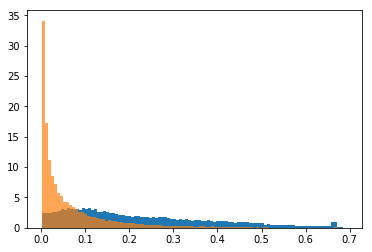

In [93]:
plt.hist( final_pos , density = True , bins = 100  )
plt.hist(  np.random.choice( final_neg , size = a)  , density = True , bins = 100 , alpha = 0.7)
plt.show()

In [79]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final }).to_csv('../data/pred_gbm_full_stack5.csv', index=False)

Plot feature importances...


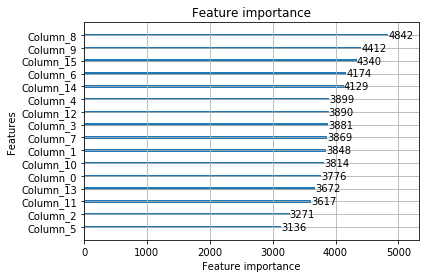

In [48]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=20)
plt.show()